# 2D Example

In [2]:
import os
import time
import torch
import scipy

from torch import nn, Tensor
from tqdm import trange
from dataset.dataset import *
from model_toy import *
from utils import *
from discrete_solver import MixtureDiscreteEulerSolver_RateGuidance
from torch.utils.data import DataLoader


# flow_matching
from flow_matching.path import MixtureDiscreteProbPath
from flow_matching.path.scheduler import PolynomialConvexScheduler
from flow_matching.solver import MixtureDiscreteEulerSolver
from flow_matching.utils import ModelWrapper
from flow_matching.loss import MixturePathGeneralizedKL
from flow_matching.path.scheduler.scheduler import SchedulerOutput, ConvexScheduler

# visualization
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

torch.manual_seed(42)

Using cpu.


In [3]:

def energy_sample(env, ss, sample_per_state=1000, **kwargs):
    data, e = inf_train_gen(env,batch_size=1000*sample_per_state)
    ori_e = e
    e = e * ss

    index = np.random.choice(1000*sample_per_state, p=scipy.special.softmax(e).squeeze(), size=sample_per_state, replace=False)
    data = data[index]
    ori_e = ori_e[index]
    return data, ori_e

def binary_sample(env, ss, sample_per_state=1000, **kwargs):
    data, e = inf_train_gen(env,batch_size=sample_per_state)
    binary_label = np.random.rand(sample_per_state) < np.exp(e.reshape(-1)) # e(x)=log p(y=1|x); label 1 with probability p = exp(e(x))
    return data, binary_label.reshape(-1)

In [4]:
class KOConvexScheduler(ConvexScheduler):
    """KO Scheduler."""

    def __call__(self, t: Tensor) -> SchedulerOutput:
        return SchedulerOutput(
            alpha_t=torch.cos(0.5 * torch.pi * (1 - t)) ** 2,
            sigma_t=torch.sin(0.5 * torch.pi * (1 - t)) ** 2,
            d_alpha_t=0.5 * torch.pi * torch.sin(torch.pi * (1 - t)),
            d_sigma_t=0 - 0.5 * torch.pi * torch.sin(torch.pi * (1 - t)),
        )


    def kappa_inverse(self, kappa: Tensor) -> Tensor:
        return 1 - torch.arccos(torch.sqrt(kappa)) * 0.5 / torch.pi

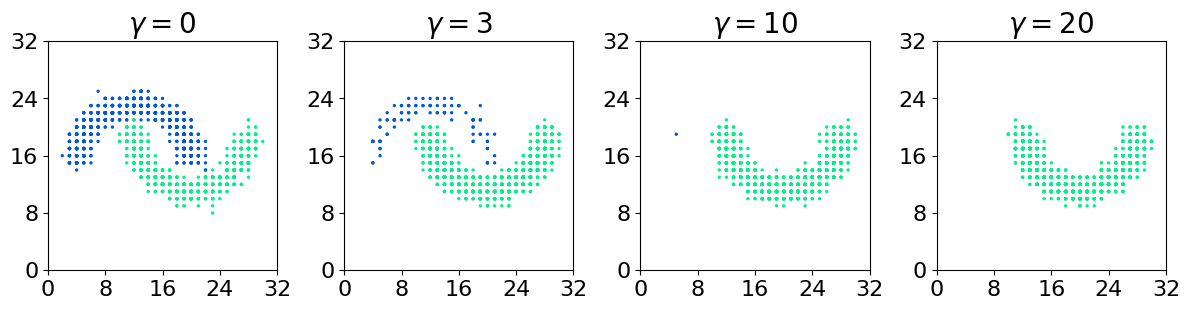

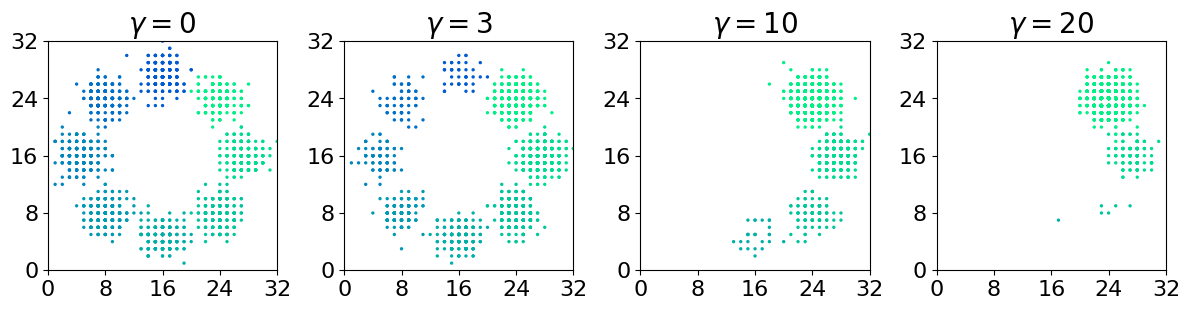

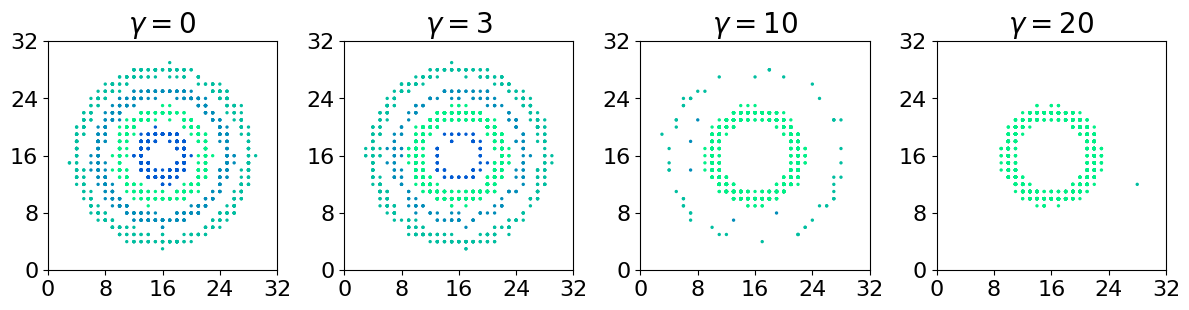

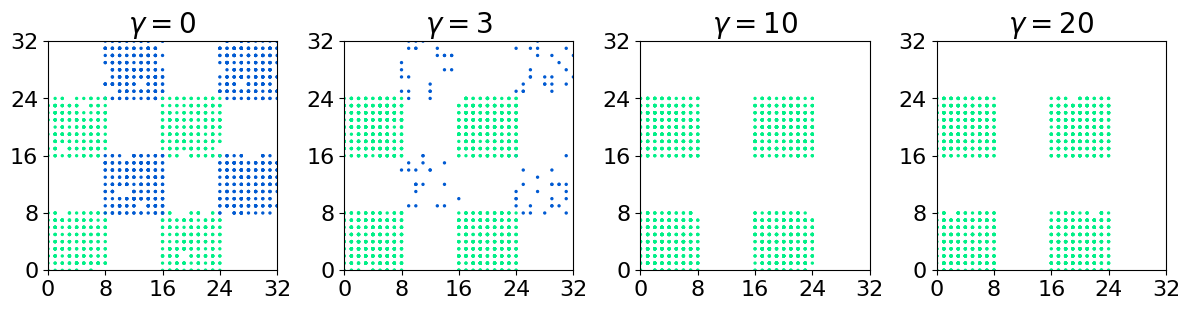

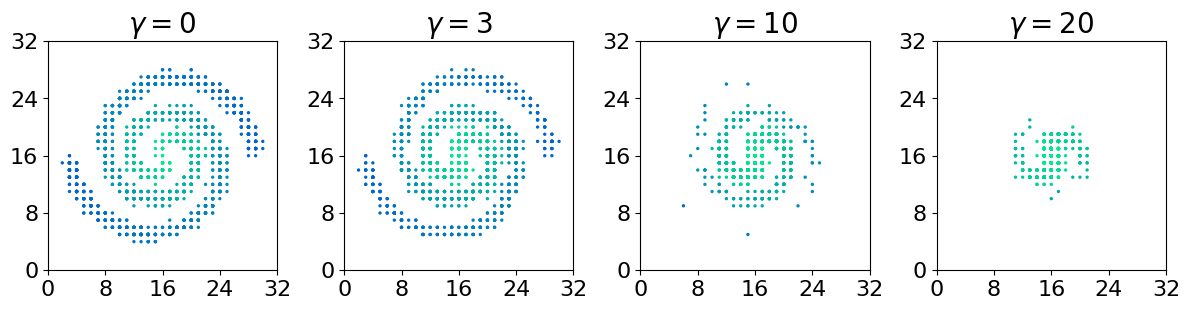

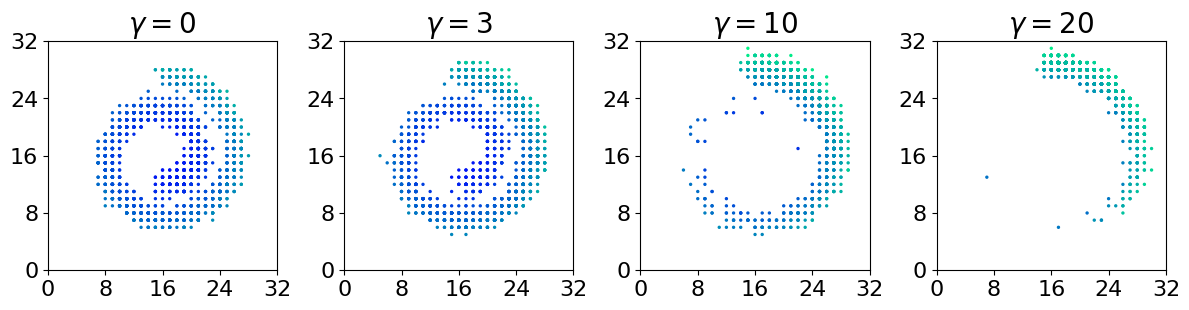

In [9]:
# scatter ground truth
for task in ["moons", "8gaussians","rings","checkerboard","2spirals","swissroll"]:
    plt.figure(figsize=(12,3))
    ss = [0, 3, 10, 20]  # energy scale (guidance strength)
    axes = []
    for i, s in enumerate(ss):
        # plt.subplot(1, len(ss) + 2, i+1)
        plt.subplot(1, len(ss), i+1)
        data, e = energy_sample(task, s, sample_per_state=2000)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim(0,32)
        plt.ylim(0,32)
        plt.scatter(data[:,0],data[:,1],s=2,c=e,cmap="winter",vmin=-1.6,vmax=0.1, rasterized=True)
        plt.yticks(ticks=range(0, 33, 8),labels=[str(i) for i in range(0, 33, 8)], fontsize=16)
        axes.append(plt.gca())
        plt.xticks(ticks=range(0, 33, 8),labels=[str(i) for i in range(0, 33, 8)], fontsize=16)
        plt.title(r'$\gamma={}$'.format(s), fontsize=20, weight='bold')
    # plt.subplot(1, len(ss) + 2, len(ss) + 1)
    # plt.gca().set_aspect('equal', adjustable='box')
    # plt.xlim(0,32)
    # plt.ylim(0,32)
    # data, e = binary_sample(task, s, sample_per_state=2000)
    # plt.scatter(data[e == 0,0], data[e == 0,1], s=1, rasterized=True)
    # plt.title(r'Negative')
    # plt.subplot(1, len(ss) + 2, len(ss) + 2)
    # plt.gca().set_aspect('equal', adjustable='box')
    # plt.xlim(0,32)
    # plt.ylim(0,32)
    # plt.scatter(data[e == 1,0], data[e == 1,1], s=1, rasterized=True)
    # plt.title(r'Positive')
    # plt.yticks(ticks=range(0, 33, 8),labels=[str(i) for i in range(0, 33, 8)])
    plt.tight_layout()
    os.makedirs("figure", exist_ok=True)
    plt.savefig(f"figure/truth_{task}.pdf", bbox_inches='tight', pad_inches=0.1)



In [2]:
source_distribution = "mask"
vocab_size = 33
if source_distribution == "uniform":
    added_token = 0
elif source_distribution == "mask":
    mask_token = vocab_size  # tokens starting from zero
    added_token = 1
else:
    raise NotImplementedError
    
# additional mask token
vocab_size += added_token
scheduler = KOConvexScheduler()  # KO scheduler
path = MixtureDiscreteProbPath(scheduler=scheduler)


In [3]:
logit_model = ToyMLP(vocab_size=vocab_size, hidden_dim=256).to(device)
log_guidance_model = RateGuidance(vocab_size=vocab_size, hidden_dim=256).to(device)
log_posterior_guidance_model = PosteriorGuidance(vocab_size=vocab_size, hidden_dim=256).to(device)

nfe = 64
step_size = 1 / nfe

safe_sampling = True
n_samples = 2000
dim = 2

if source_distribution == "uniform":
    x_init = torch.randint(size=(n_samples, dim), high=vocab_size, device=device)
elif source_distribution == "mask":
    x_init = (torch.zeros(size=(n_samples, dim), device=device) + mask_token).long()
else:
    raise NotImplementedError


## Discrete Guidance in Nisonoff et al. (2024) (Masked Initial Distribution)

[]

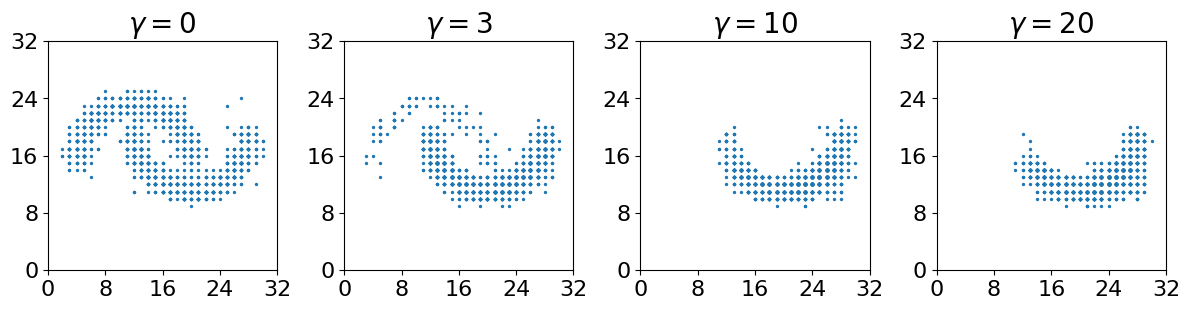

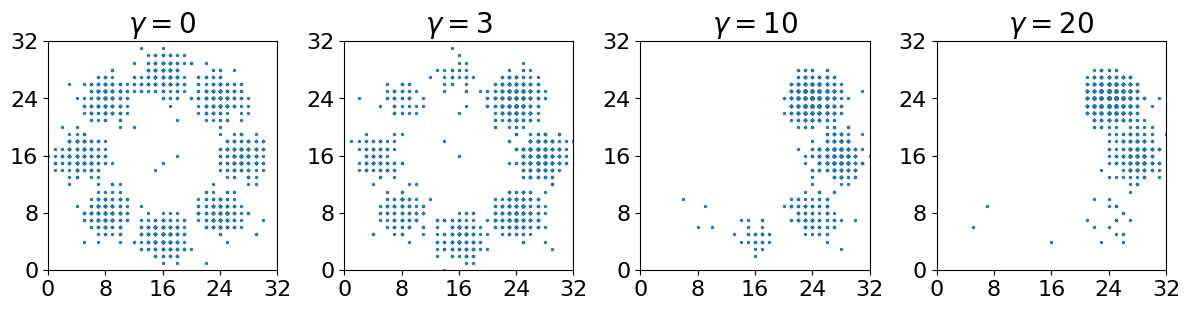

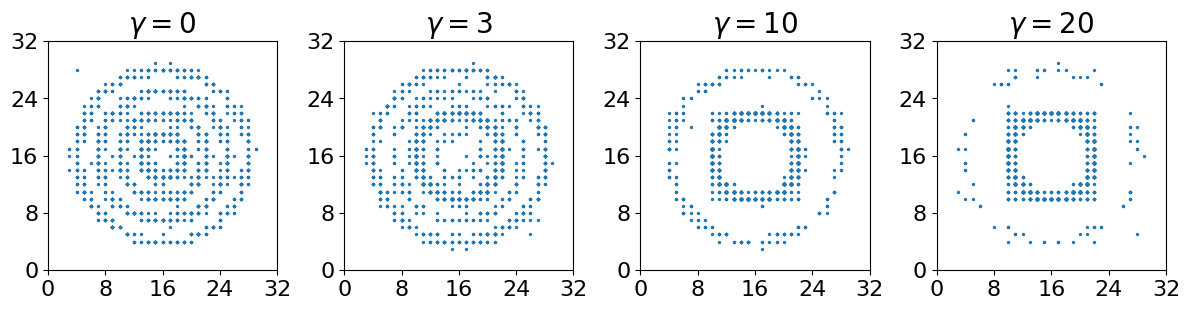

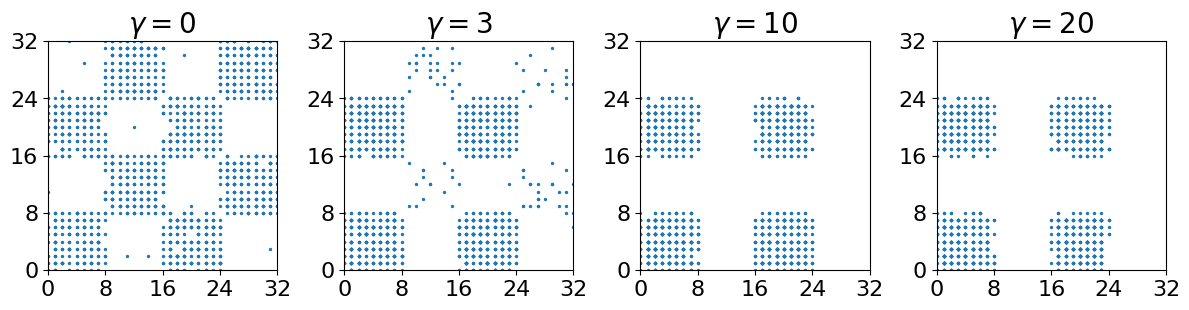

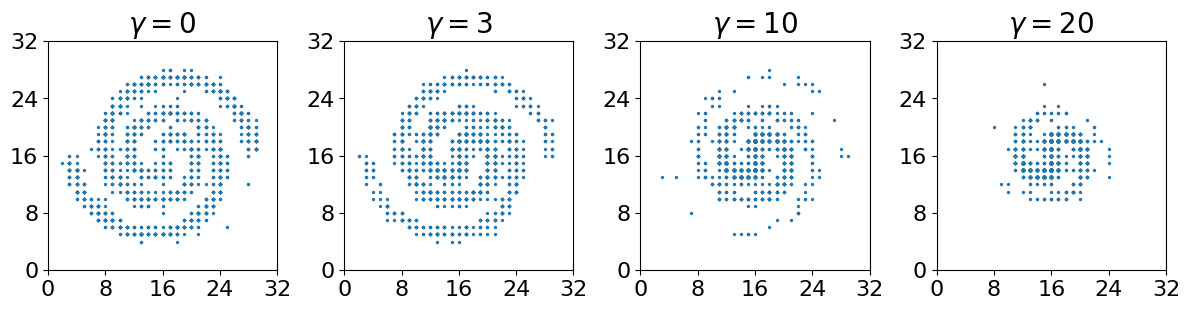

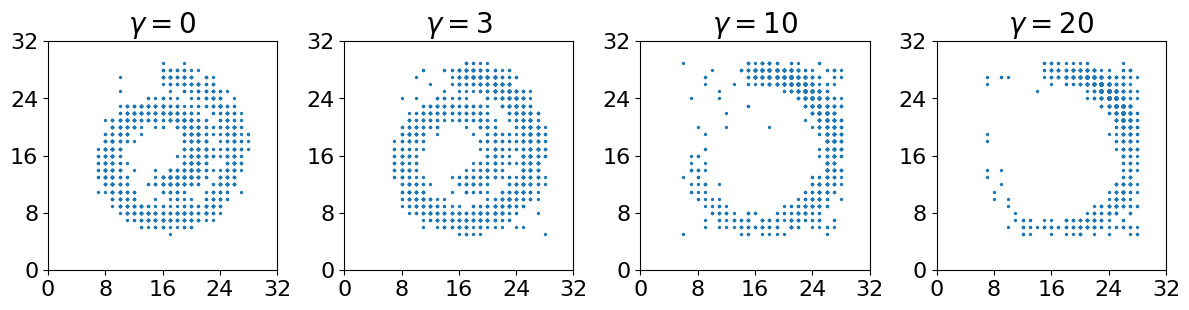

In [12]:
# for task in ["8gaussians", "moons", "swissroll"]:
for task in ["moons", "8gaussians","rings","checkerboard","2spirals","swissroll"]:
    ckpt_posterior = torch.load(os.path.join("./models", "toy_{}".format(source_distribution),"{}/ckpt100.pth".format(task)), map_location=device)
    logit_model.load_state_dict(ckpt_posterior)
    posterior_model = WrappedModel(logit_model)
    plt.figure(figsize=(12,3.0))
    ss = [0, 3, 10, 20]
    axes = []
    for i, s in enumerate(ss):
        plt.subplot(1, len(ss), i+1)
        ckpt_guidance = torch.load(os.path.join("./models", "toy_{}".format(source_distribution),"{}/{}/ckpt50.pth".format(task, 1)), map_location=device)
        log_guidance_model.load_state_dict(ckpt_guidance)
        guidance_model = GuidanceModelWrapper(log_guidance_model).to(device)
        solver = MixtureDiscreteEulerSolver_RateGuidance(model=posterior_model, path=path, vocabulary_size=vocab_size, guidance_model=guidance_model)
        sol = solver.sample(x_init=x_init, # (n_samples, 2)
                    step_size=step_size, 
                    verbose=False, 
                    return_intermediates=False,
                    guidance_strength=s)



        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim(0,32)
        plt.ylim(0,32)
        plt.scatter(sol[:,0],sol[:,1],s=2,rasterized=True)
        plt.xticks(ticks=range(0, 33, 8),labels=[str(i) for i in range(0, 33, 8)], fontsize=16)
        plt.yticks(ticks=range(0, 33, 8),labels=[str(i) for i in range(0, 33, 8)], fontsize=16)
        axes.append(plt.gca())
        plt.title(r'$ \gamma ={}$'.format(s), fontsize=20, weight='bold')
    plt.tight_layout()
    os.makedirs("figure", exist_ok=True)
    plt.savefig(f"figure/rate_nisonoff_{task}.pdf", bbox_inches='tight', pad_inches=0.1)
plt.plot()


## Exact Rate-Based Guidance (Masked Initial Distribution)

[]

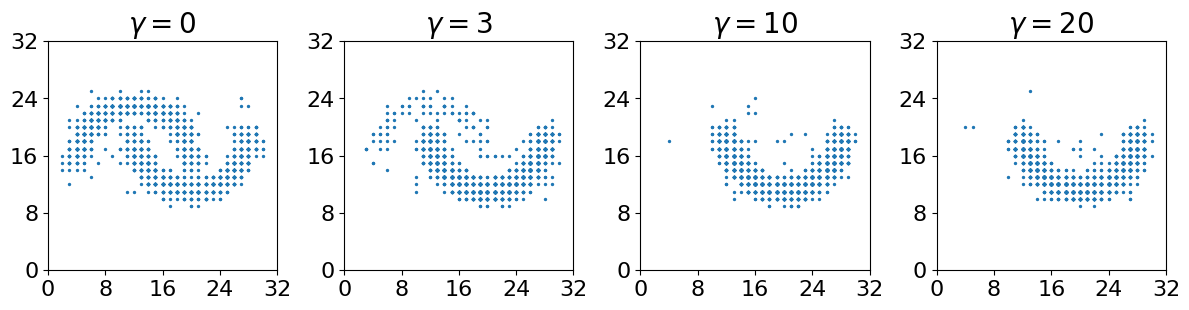

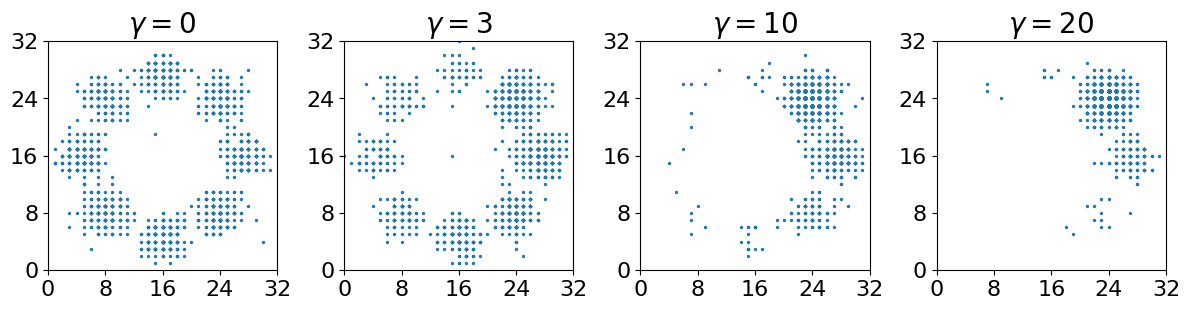

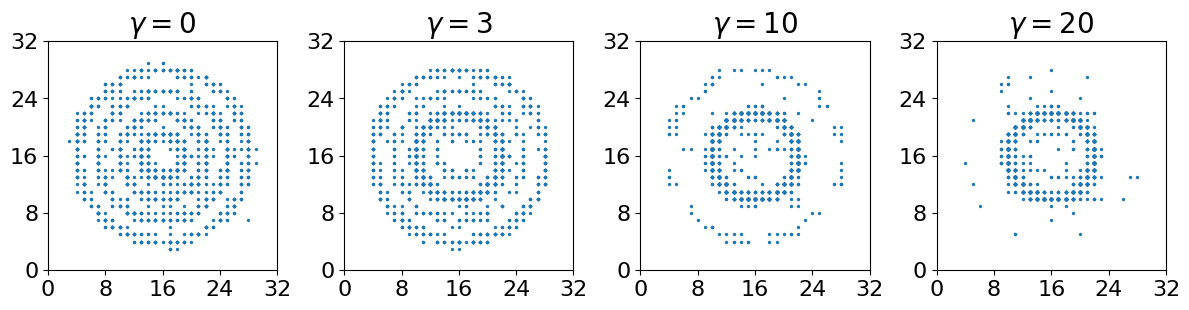

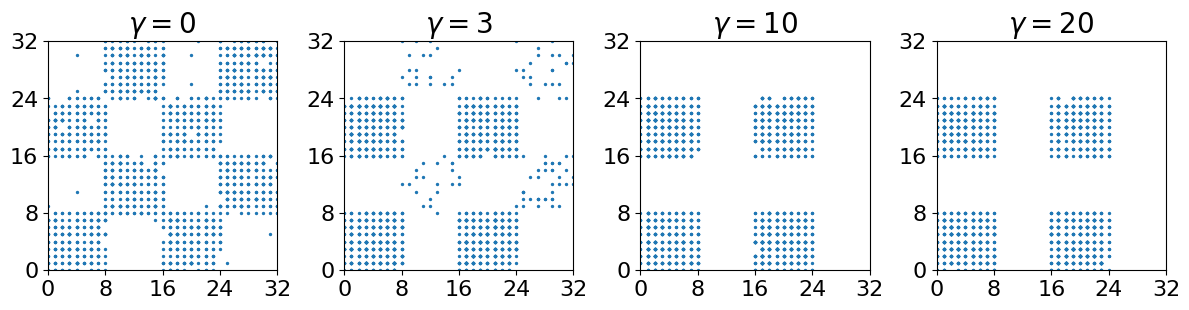

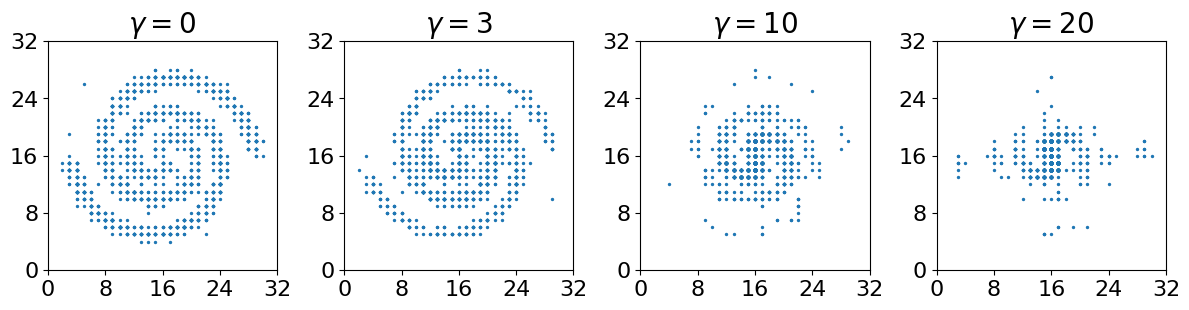

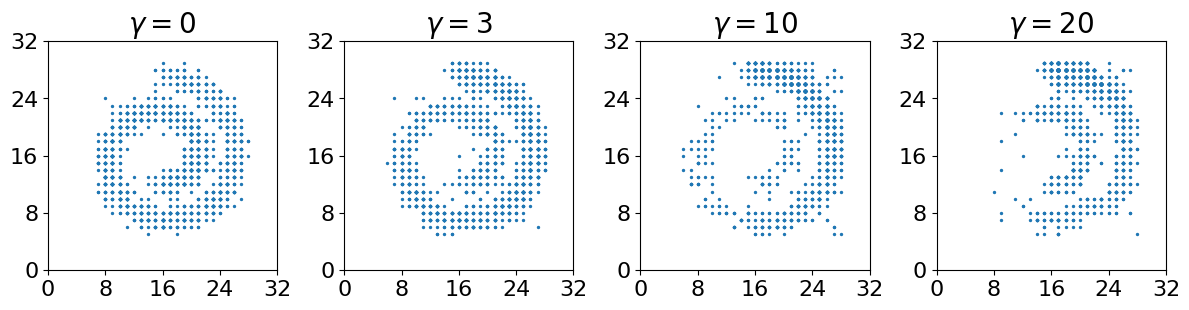

In [13]:
for task in ["moons", "8gaussians","rings","checkerboard","2spirals","swissroll"]:
    ckpt_posterior = torch.load(os.path.join("./models", "toy_{}".format(source_distribution),"{}/ckpt100.pth".format(task)), map_location=device)
    logit_model.load_state_dict(ckpt_posterior)
    posterior_model = WrappedModel(logit_model)
    plt.figure(figsize=(12,3.0))
    ss = [0, 3, 10, 20]  # energy scale (guidance strength)
    axes = []
    for i, s in enumerate(ss):
        plt.subplot(1, len(ss), i+1)
        if s == 0:
            solver = MixtureDiscreteEulerSolver_RateGuidance(model=posterior_model, path=path, vocabulary_size=vocab_size)
            sol = solver.sample(x_init=x_init, # (n_samples, 2)
                    step_size=step_size, 
                    verbose=False, 
                    return_intermediates=False)
        else:
            ckpt_guidance = torch.load(os.path.join("./models", "toy_{}".format(source_distribution),"{}/{}/ckpt50.pth".format(task, s)), map_location=device)
            log_guidance_model.load_state_dict(ckpt_guidance)
            guidance_model = GuidanceModelWrapper(log_guidance_model).to(device)
            solver = MixtureDiscreteEulerSolver_RateGuidance(model=posterior_model, path=path, vocabulary_size=vocab_size, guidance_model=guidance_model)
            sol = solver.sample(x_init=x_init, # (n_samples, 2)
                        step_size=step_size, 
                        verbose=False, 
                        return_intermediates=False)

        



        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim(0,32)
        plt.ylim(0,32)
        plt.scatter(sol[:,0],sol[:,1],s=2,rasterized=True)
        plt.xticks(ticks=range(0, 33, 8),labels=[str(i) for i in range(0, 33, 8)], fontsize=16)
        plt.yticks(ticks=range(0, 33, 8),labels=[str(i) for i in range(0, 33, 8)], fontsize=16)
        axes.append(plt.gca())
        plt.title(r'$ \gamma ={}$'.format(s), fontsize=20, weight='bold')
    plt.tight_layout()
    os.makedirs("figure", exist_ok=True)
    plt.savefig(f"figure/exact_rate_{task}.pdf", bbox_inches='tight', pad_inches=0.1)
plt.plot()

## Exact Posterior-Based Guidance (Masked Initial Distribution)

[]

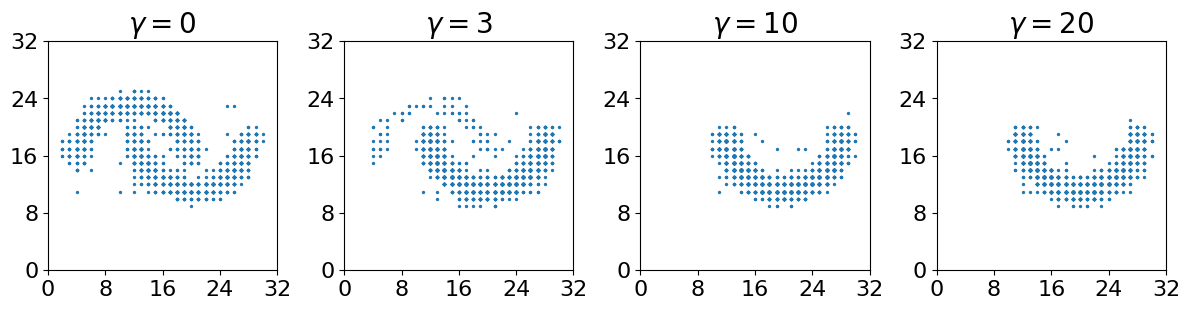

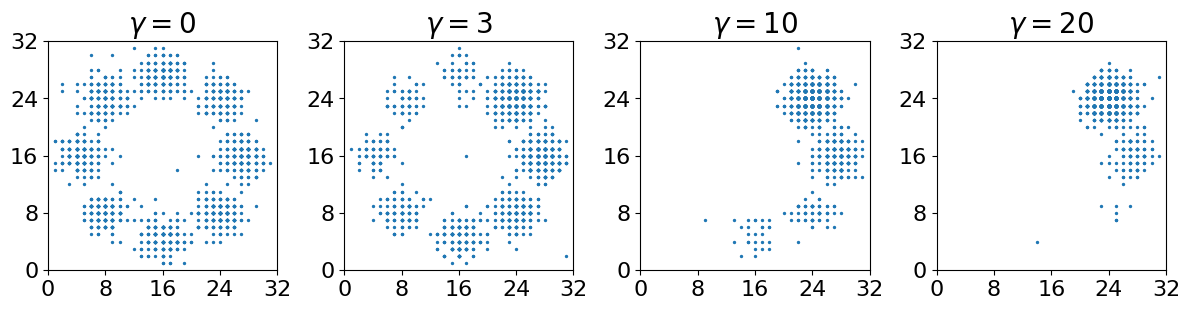

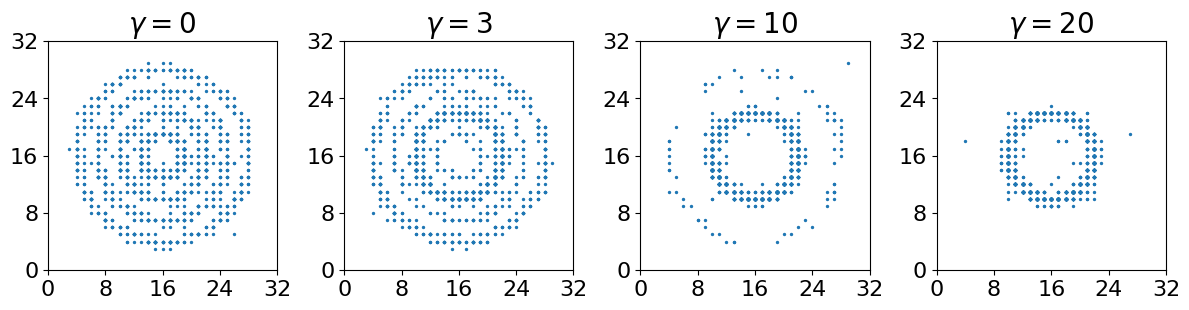

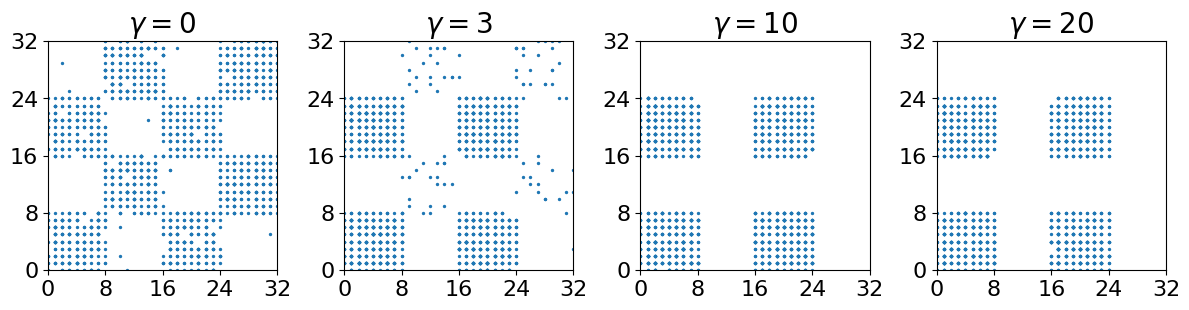

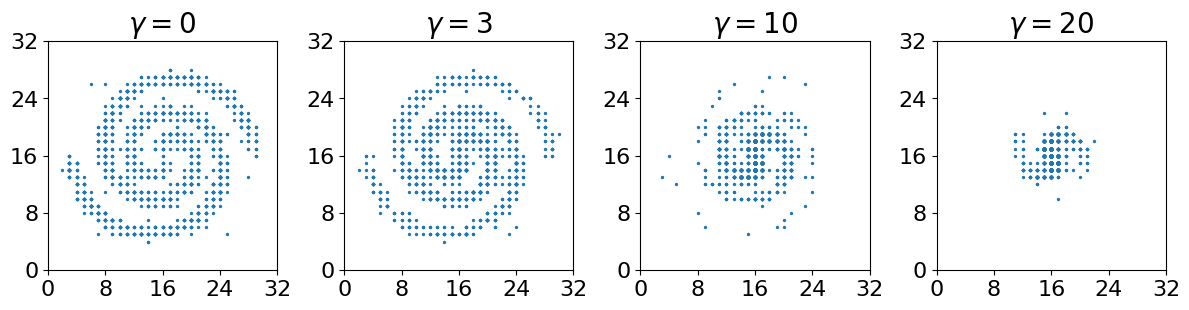

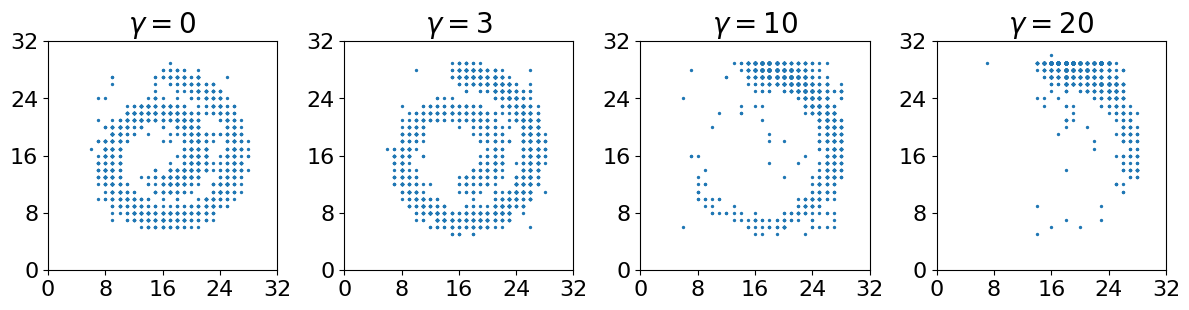

In [14]:
for task in ["moons", "8gaussians","rings","checkerboard","2spirals","swissroll"]:
    ckpt_posterior = torch.load(os.path.join("./models", "toy_{}".format(source_distribution),"{}/ckpt50.pth".format(task)), map_location=device)
    logit_model.load_state_dict(ckpt_posterior)
    posterior_model = WrappedModel(logit_model)
    plt.figure(figsize=(12,3.0))
    ss = [0, 3,10,20]
    axes = []
    for i, s in enumerate(ss):
        plt.subplot(1, len(ss), i+1)
        if s == 0:
            solver = MixtureDiscreteEulerSolver(model=posterior_model, path=path, vocabulary_size=vocab_size)
            sol = solver.sample(x_init=x_init, # (n_samples, 2)
                    step_size=step_size, 
                    verbose=False, 
                    return_intermediates=False)
        else:
            ckpt_guidance = torch.load(os.path.join("./models", "toy_{}".format(source_distribution),"{}/{}/posterior_ckpt50.pth".format(task, s)), map_location=device)
            log_posterior_guidance_model.load_state_dict(ckpt_guidance)
            posterior_guidance_model = GuidanceModelWrapper(log_posterior_guidance_model).to(device)
            guided_posterior_model = WrappedConditionalProb(posterior_model, posterior_guidance_model)
            solver = MixtureDiscreteEulerSolver(model=guided_posterior_model, path=path, vocabulary_size=vocab_size)
            sol = solver.sample(x_init=x_init, # (n_samples, 2)
                        step_size=step_size, 
                        verbose=False, 
                        return_intermediates=False)

        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim(0,32)
        plt.ylim(0,32)
        plt.scatter(sol[:,0],sol[:,1],s=2,rasterized=True)
        plt.xticks(ticks=range(0, 33, 8),labels=[str(i) for i in range(0, 33, 8)], fontsize=16)
        plt.yticks(ticks=range(0, 33, 8),labels=[str(i) for i in range(0, 33, 8)], fontsize=16)
        axes.append(plt.gca())
        plt.title(r'$ \gamma ={}$'.format(s), fontsize=20, weight='bold')
    plt.tight_layout()
    os.makedirs("figure", exist_ok=True)
    plt.savefig(f"figure/posterior_mask_{task}.pdf", bbox_inches='tight', pad_inches=0.1)
plt.plot()

## Exact Posterior-Based Guidance (Uniform Initial Distribution)

[]

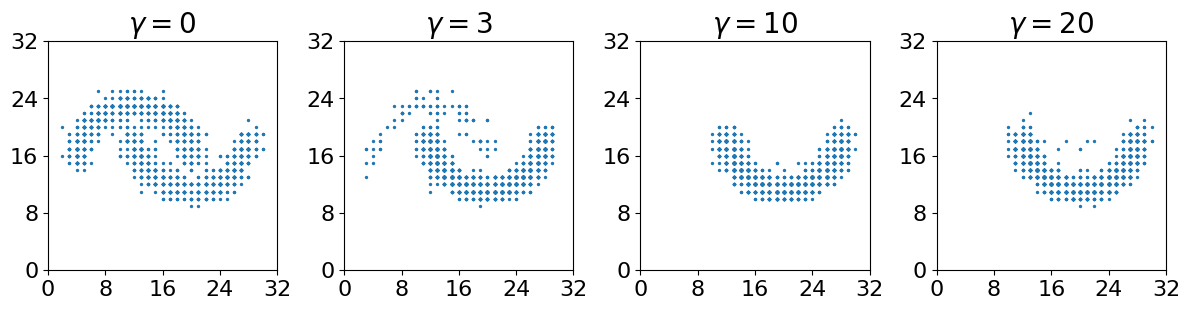

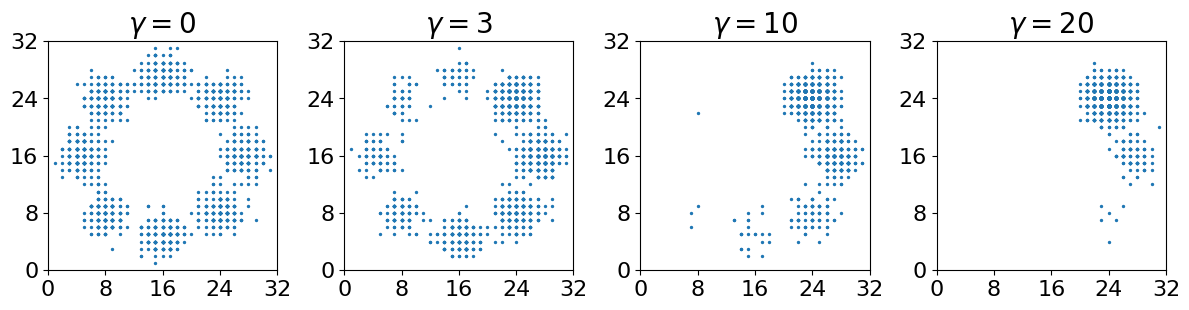

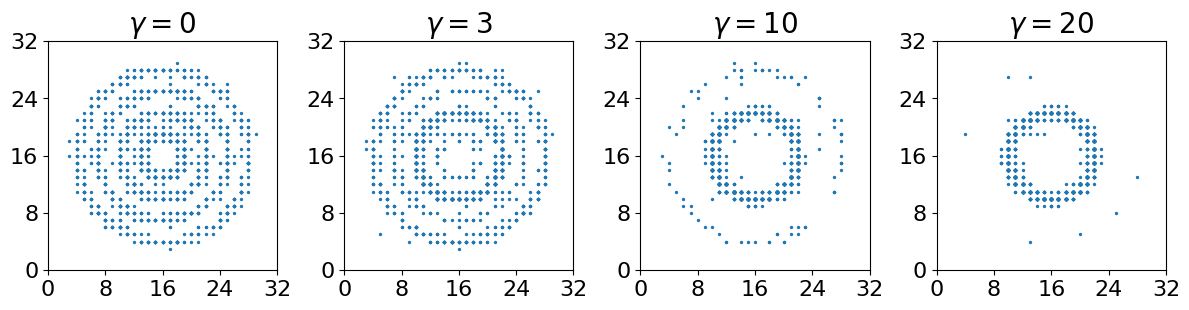

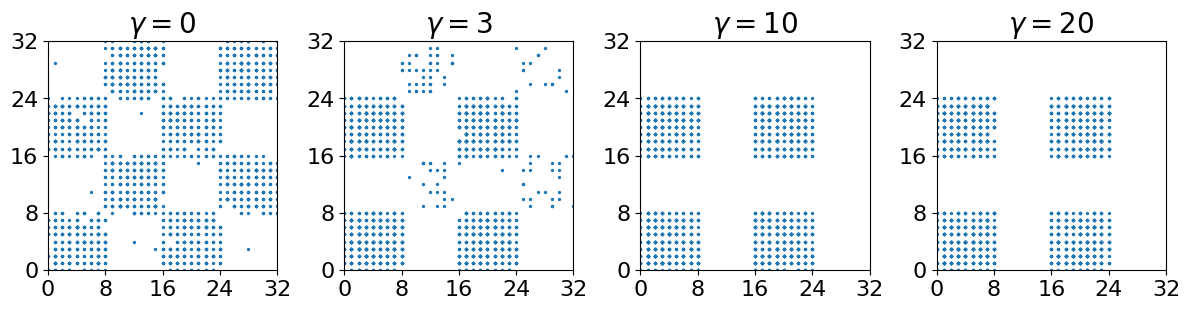

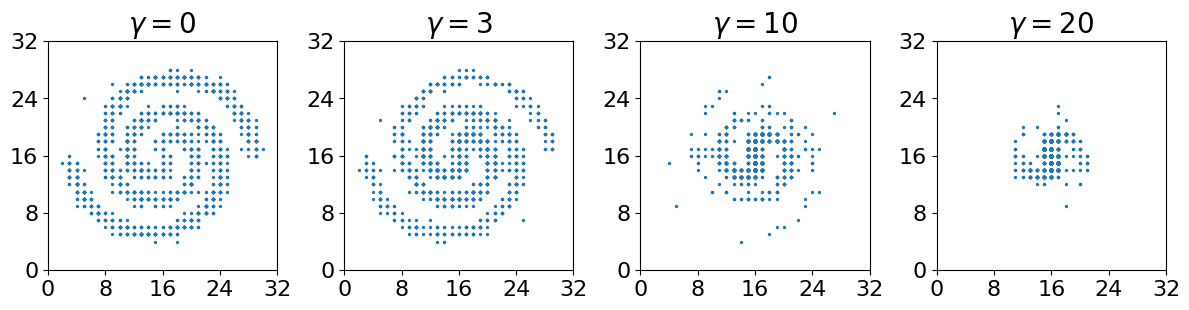

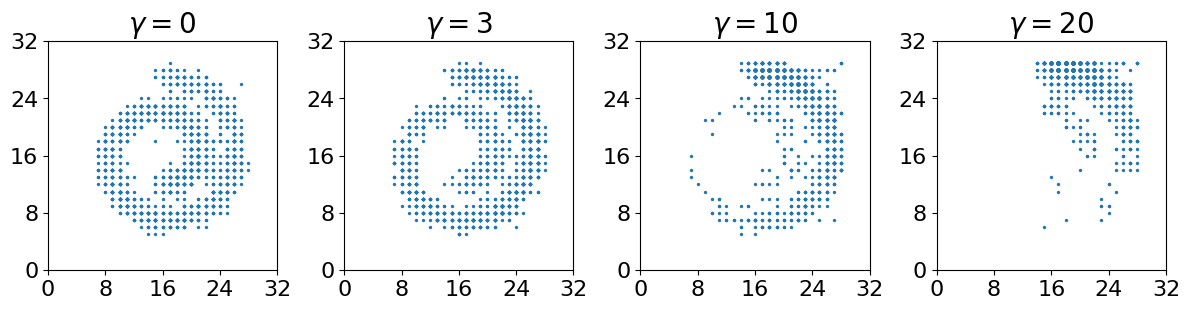

In [15]:
source_distribution = "uniform"
vocab_size = 33
if source_distribution == "uniform":
    added_token = 0
elif source_distribution == "mask":
    mask_token = vocab_size  # tokens starting from zero
    added_token = 1
else:
    raise NotImplementedError
logit_model = ToyMLP(vocab_size=vocab_size, hidden_dim=256).to(device)
log_posterior_guidance_model = PosteriorGuidance(vocab_size=vocab_size, hidden_dim=256).to(device)
if source_distribution == "uniform":
    x_init = torch.randint(size=(n_samples, dim), high=vocab_size, device=device)
elif source_distribution == "mask":
    x_init = (torch.zeros(size=(n_samples, dim), device=device) + mask_token).long()
else:
    raise NotImplementedError
for task in ["moons", "8gaussians","rings","checkerboard","2spirals","swissroll"]:
    ckpt_posterior = torch.load(os.path.join("./models", "toy_{}".format(source_distribution),"{}/ckpt100.pth".format(task)), map_location=device)
    logit_model.load_state_dict(ckpt_posterior)
    posterior_model = WrappedModel(logit_model)
    plt.figure(figsize=(12,3.0))
    ss = [0, 3, 10, 20]
    axes = []
    for i, s in enumerate(ss):
        plt.subplot(1, len(ss), i+1)
        if s == 0:
            solver = MixtureDiscreteEulerSolver(model=posterior_model, path=path, vocabulary_size=vocab_size)
            sol = solver.sample(x_init=x_init, # (n_samples, 2)
                    step_size=step_size, 
                    verbose=False, 
                    return_intermediates=False)
        else:
            ckpt_guidance = torch.load(os.path.join("./models", "toy_{}".format(source_distribution),"{}/{}/posterior_ckpt50.pth".format(task, s)), map_location=device)
            log_posterior_guidance_model.load_state_dict(ckpt_guidance)
            posterior_guidance_model = GuidanceModelWrapper(log_posterior_guidance_model).to(device)
            guided_posterior_model = WrappedConditionalProb(posterior_model, posterior_guidance_model)
            solver = MixtureDiscreteEulerSolver(model=guided_posterior_model, path=path, vocabulary_size=vocab_size)
            sol = solver.sample(x_init=x_init, # (n_samples, 2)
                        step_size=step_size, 
                        verbose=False, 
                        return_intermediates=False)

        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim(0,32)
        plt.ylim(0,32)
        plt.scatter(sol[:,0],sol[:,1],s=2,rasterized=True)
        plt.xticks(ticks=range(0, 33, 8),labels=[str(i) for i in range(0, 33, 8)], fontsize=16)
        plt.yticks(ticks=range(0, 33, 8),labels=[str(i) for i in range(0, 33, 8)], fontsize=16)
        axes.append(plt.gca())
        plt.title(r'$ \gamma ={}$'.format(s), fontsize=20, weight='bold')
    plt.tight_layout()
    os.makedirs("figure", exist_ok=True)
    plt.savefig(f"figure/posterior_uniform_{task}.pdf", bbox_inches='tight', pad_inches=0.1)
plt.plot()

## Sampling Time

In [5]:
source_distribution = "mask"
vocab_size = 33
if source_distribution == "uniform":
    added_token = 0
elif source_distribution == "mask":
    mask_token = vocab_size  # tokens starting from zero
    added_token = 1
else:
    raise NotImplementedError
    
# additional mask token
vocab_size += added_token
scheduler = KOConvexScheduler()  # KO scheduler
path = MixtureDiscreteProbPath(scheduler=scheduler)

logit_model = ToyMLP(vocab_size=vocab_size, hidden_dim=256).to(device)
log_guidance_model_rate = RateGuidance(vocab_size=vocab_size, hidden_dim=256).to(device)
log_guidance_model_pred = RateGuidance(vocab_size=vocab_size, hidden_dim=256).to(device)
log_posterior_guidance_model = PosteriorGuidance(vocab_size=vocab_size, hidden_dim=256).to(device)


safe_sampling = True
n_samples = 2000
dim = 2

if source_distribution == "uniform":
    x_init = torch.randint(size=(n_samples, dim), high=vocab_size, device=device)
elif source_distribution == "mask":
    x_init = (torch.zeros(size=(n_samples, dim), device=device) + mask_token).long()
else:
    raise NotImplementedError

task = "rings"
ckpt_posterior = torch.load(os.path.join("./models", "toy_{}".format(source_distribution),"{}/ckpt100.pth".format(task)), map_location=device)
logit_model.load_state_dict(ckpt_posterior)
posterior_model = WrappedModel(logit_model)
s = 3

# predictor guidance proposed by Nisonoff et al.
ckpt_guidance = torch.load(os.path.join("./models", "toy_{}".format(source_distribution),"{}/{}/ckpt50.pth".format(task, 1)), map_location=device)
log_guidance_model_pred.load_state_dict(ckpt_guidance)
guidance_model_pred = GuidanceModelWrapper(log_guidance_model_pred).to(device)
solver = MixtureDiscreteEulerSolver_RateGuidance(model=posterior_model, path=path, vocabulary_size=vocab_size, guidance_model=guidance_model_pred)

# rate-based guidance proposed in this paper
ckpt_guidance = torch.load(os.path.join("./models", "toy_{}".format(source_distribution),"{}/{}/ckpt50.pth".format(task, s)), map_location=device)
log_guidance_model_rate.load_state_dict(ckpt_guidance)
guidance_model_rate = GuidanceModelWrapper(log_guidance_model_rate).to(device)
solver = MixtureDiscreteEulerSolver_RateGuidance(model=posterior_model, path=path, vocabulary_size=vocab_size, guidance_model=guidance_model_rate)

# posterior-based guidance proposed in this paper
ckpt_guidance = torch.load(os.path.join("./models", "toy_{}".format(source_distribution),"{}/{}/posterior_ckpt50.pth".format(task, s)), map_location=device)
log_posterior_guidance_model.load_state_dict(ckpt_guidance)
posterior_guidance_model = GuidanceModelWrapper(log_posterior_guidance_model).to(device)
guided_posterior_model = WrappedConditionalProb(posterior_model, posterior_guidance_model)
solver = MixtureDiscreteEulerSolver(model=guided_posterior_model, path=path, vocabulary_size=vocab_size)

def measure_sample_time(fn, *args, **kwargs):
    t0 = time.perf_counter()
    out = fn(*args, **kwargs)
    t1 = time.perf_counter()
    return t1 - t0, out


predictor_times = []
rate_times = []
posterior_times = []
nfe_list = [32, 64, 128, 256, 512, 1024]
for nfe in nfe_list:
    step_size = 1 / nfe

    # predictor guidance（Nisonoff et al.）
    solver_pred = MixtureDiscreteEulerSolver_RateGuidance(model=posterior_model, path=path, vocabulary_size=vocab_size, guidance_model=guidance_model_pred)
    t_pred, _ = measure_sample_time(solver_pred.sample, x_init=x_init, step_size=step_size, verbose=False, return_intermediates=False, guidance_strength=s)
    predictor_times.append(t_pred)

    # rate-based guidance（paper）
    solver_rate = MixtureDiscreteEulerSolver_RateGuidance(model=posterior_model, path=path, vocabulary_size=vocab_size, guidance_model=guidance_model_rate)
    t_rate, _ = measure_sample_time(solver_rate.sample, x_init=x_init, step_size=step_size, verbose=False, return_intermediates=False)
    rate_times.append(t_rate)

    # posterior-based guidance（paper）
    solver_post = MixtureDiscreteEulerSolver(model=guided_posterior_model, path=path, vocabulary_size=vocab_size)
    t_post, _ = measure_sample_time(solver_post.sample, x_init=x_init, step_size=step_size, verbose=False, return_intermediates=False)
    posterior_times.append(t_post)

    print(f"nfe={nfe}: pred={t_pred:.3f}s, rate={t_rate:.3f}s, post={t_post:.3f}s")


nfe=32: pred=0.386s, rate=0.415s, post=0.250s
nfe=64: pred=0.780s, rate=0.771s, post=0.467s
nfe=128: pred=1.503s, rate=1.432s, post=0.879s
nfe=256: pred=2.890s, rate=2.870s, post=1.753s
nfe=512: pred=5.759s, rate=5.827s, post=3.538s
nfe=1024: pred=11.625s, rate=11.638s, post=7.149s


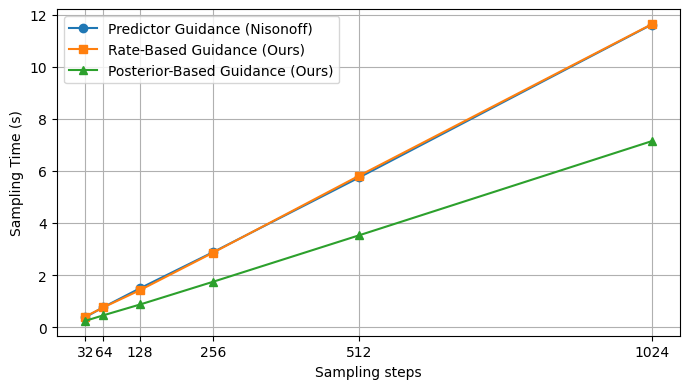

In [ ]:
os.makedirs("figure", exist_ok=True)
plt.figure(figsize=(7,4))
plt.plot(nfe_list, predictor_times, marker='o', label='Predictor Guidance (Nisonoff)')
plt.plot(nfe_list, rate_times, marker='s', label='Rate-Based Guidance (Ours)')
plt.plot(nfe_list, posterior_times, marker='^', label='Posterior-Based Guidance (Ours)')
plt.xlabel('Sampling steps')
plt.ylabel('Sampling Time (s)')
plt.xticks(nfe_list, nfe_list, fontsize=10)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figure/sampling_time_vs_sampling_steps.pdf", dpi=150)
plt.show()

